# UTS Analisis Teks
# Eko Ikhwan Saputra

Link github : https://github.com/ulung3ko/uts-analisis-teks

In [1]:
# Import Library yang diubutuhkan
import pandas as pd
import numpy as np
import matplotlib as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Bagian 0
# Artikel Terkini
Artikel yang diangkat berjudul "Pemain Timnas Indonesia Terbang ke Bali, Bersiap Bela Garuda" dari CNN Indonesia. Artikel berisi kabar terbaru tentang persiapan Timnas Indonesia untuk Kualifikasi Piala Dunia 2026.  
Sumber : https://www.cnnindonesia.com/olahraga/20250525071942-142-1232869/pemain-timnas-indonesia-terbang-ke-bali-bersiap-bela-garuda

# Isu Permasalahan
Topik Timnas Indonesia secara konsisten menjadi perhatian publik di media sosial terutama menjelang pertandingan. Di balik semangat dukungan, muncul juga kritik terhadap performa pemain, strategi pelatih, dan keputusan federasi. Cara konvensional susah untuk memahami kecenderungan sentimen publik.

# Solusi dengan Klasifikasi Teks
Permasalahan ini dapat diselesaikan dengan membangun model klasifikasi teks yang secara otomatis mengidentifikasi sentimen publik (positif atau negatif) terhadap Timnas Indonesia. Model akan membantu dalam menganalisis opini masyarakat secara cepat dan sistematis sebagai bahan evaluasi dan strategi komunikasi publik.


# Bagian 1
Dataset yang digunakan adalah "Analisis Sentimen Timnas Sepakbola di Era STY" dari Kaggle, terdiri dari.
- 398 baris data.
- 2 kolom: komentar dan label.
- Label berupa positive dan negative.

Memang judul dataset menyebut era STY,  tapi dataset ini tetap relevan karena berisi opini publik terhadap Timnas secara umum.

Sumber : https://www.kaggle.com/datasets/pajarbebek/analisis-sentimen-timnas-sepakbola-di-era-sty

In [2]:
# Baca dan lihat 5 baris dataser
df = pd.read_csv('data_sentiment_timnas.csv')
df.head()

,komentar,label
0,<username> Simulasi indonesia kembali dijajah ...,negatif
1,<username> <username> <username> keturunan lai...,negatif
2,<username> <username> uda botak keturunan penj...,negatif
3,"<username> <username> <username> Belum tentu, ...",negatif
4,<username> <username> <username> Lu nya aja yg...,negatif


In [3]:
# Melihat statistik dasar dataset
jumlah_kategori = df['label'].nunique()
print(f"Jumlah kategori unik dalam kolom 'label': {jumlah_kategori}")

kategori_unik = df['label'].unique()
print(f"Kategori unik dalam kolom 'label': {kategori_unik}")

print("\nInformasi Dataset:")
df.info()

print("\nDeskripsi Statistik Dataset:")
print(df.describe(include='all'))

Jumlah kategori unik dalam kolom 'label': 2
Kategori unik dalam kolom 'label': ['negatif' 'positif']

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   komentar  398 non-null    object
 1   label     398 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB

Deskripsi Statistik Dataset:
                                                 komentar    label
count                                                 398      398
unique                                                393        2
top     <username> Dendy sama arhan punya aib nya sty ...  positif
freq                                                    2      204


# Bagian 2
Pra-premsosesan Teks dilakukan sesuai dengan instruksi yaitu.
- Tokenisasi.
- Penghapusan stopwords.
- Stemming.
- Case Folding.
- Hapus tanda baca dan karakter khusus.

In [4]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
list_stopwords_nltk = stopwords.words('indonesian')
custom_stopwords = ['username', 'nya', 'ma', 'tp', 'mah', 'jg', 'sih', 'tdk', 'utk', 'deh', 'jd', 'lg', 'gk', 'ga', 'gak', 'yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'klo', 'kalo', 'amp', 'biar', 'bikin', 'bilang', 'krn'] 
list_stopwords = set(list_stopwords_nltk + custom_stopwords)

# Fungsi Pre-processing
def preprocess_text(text):
    # Memastikan input adalah string dan menangani nilai NaN
    if pd.isna(text):
        return ""
    text = str(text)

    # 1. Lowercasing: Mengubah semua teks menjadi huruf kecil
    text = text.lower()

    # 2. Hapus tanda baca dan karakter khusus (mempertahankan huruf dan spasi)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()

    # 3. Tokenisasi: Memecah teks menjadi token (kata)
    tokens = word_tokenize(text)

    # 4. Penghapusan Stopwords
    tokens_without_stopwords = [word for word in tokens if word not in list_stopwords and len(word) > 1] # Opsi: len(word)>1 untuk hapus token 1 huruf

    # 5. Stemming: Mengubah kata menjadi bentuk dasarnya
    if 'stemmer' in globals():
        stemmed_tokens = [stemmer.stem(word) for word in tokens_without_stopwords]
    else:
        stemmed_tokens = tokens_without_stopwords # Lanjutkan tanpa stemming jika Sastrawi gagal

    # Menggabungkan kembali token menjadi satu string teks
    processed_text = " ".join(stemmed_tokens)
    return processed_text

print("DataFrame Asli (beberapa baris pertama):")
print(df.head())
print("-" * 50)

# 2. Apply  ke kolom 'komentar'
print("\nMemulai pra-pemrosesan pada kolom 'komentar'...")
df['komentar_bersih'] = df['komentar'].apply(preprocess_text)
print("Pra-pemrosesan selesai.")
print("-" * 50)

DataFrame Asli (beberapa baris pertama):
                                            komentar    label
0  <username> Simulasi indonesia kembali dijajah ...  negatif
1  <username> <username> <username> keturunan lai...  negatif
2  <username> <username> uda botak keturunan penj...  negatif
3  <username> <username> <username> Belum tentu, ...  negatif
4  <username> <username> <username> Lu nya aja yg...  negatif
--------------------------------------------------

Memulai pra-pemrosesan pada kolom 'komentar'...
Pra-pemrosesan selesai.
--------------------------------------------------


In [6]:
# Hasil pre-processing
print(df.head())
print("-" * 50)

                                            komentar    label  \
0  <username> Simulasi indonesia kembali dijajah ...  negatif   
1  <username> <username> <username> keturunan lai...  negatif   
2  <username> <username> uda botak keturunan penj...  negatif   
3  <username> <username> <username> Belum tentu, ...  negatif   
4  <username> <username> <username> Lu nya aja yg...  negatif   

                                     komentar_bersih  
0  simulasi indonesia jajah turun belanda depan b...  
1  turun main bola emang naturalisasi istimewa pe...  
2  uda botak turun jajah sok si paham bola lu coa...  
3  main bola milih karir main bola kualitas timna...  
4  lu aja bego nonton tolol persepsi orang beda n...  
--------------------------------------------------


# Bagian 3
Feature Engineering menggunakan TF-IDF dan Word2Vec sesuai instruksi.

In [7]:
# 1. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000,
                                   min_df=3,
                                   ngram_range=(1, 2),
                                   max_df=0.8)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['komentar_bersih'])

print(f"\nBentuk (shape) dari TF-IDF matrix: {tfidf_matrix.shape}")

# Menampilkan beberapa nama fitur (kata-kata yang menjadi kolom di TF-IDF)
print("\nBeberapa contoh nama fitur TF-IDF:")
try:
    feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
    print(feature_names_tfidf[:20])
except Exception as e:
    print(f"Tidak bisa mendapatkan nama fitur: {e}")

# 2. Word2Vec
from gensim.models import Word2Vec

tokenized_comments_for_w2v = df['komentar_bersih'].apply(lambda x: x.split())
vector_size_w2v = 100
w2v_model = Word2Vec(sentences=tokenized_comments_for_w2v,
                     vector_size=vector_size_w2v,
                     window=3,
                     min_count=3,
                     workers=4,
                     sg=1)

def document_vector_w2v(doc_tokens, model, num_features):
    words_in_vocab = [word for word in doc_tokens if word in model.wv]

    if not words_in_vocab:
        return np.zeros(num_features)
    vector_sum = np.sum([model.wv[word] for word in words_in_vocab], axis=0)
    doc_vector = vector_sum / len(words_in_vocab)
    return doc_vector

# Buat vektor
print("\nMembuat fitur vektor dokumen dari Word2Vec...")
w2v_document_features_list = [document_vector_w2v(tokens, w2v_model, vector_size_w2v) for tokens in tokenized_comments_for_w2v]

# Vektor ke dataframe
df_w2v_features = pd.DataFrame(w2v_document_features_list, columns=[f'w2v_feat_{i}' for i in range(vector_size_w2v)])

print(f"\nBentuk (shape) dari DataFrame fitur Word2Vec: {df_w2v_features.shape}")
print("\nContoh DataFrame Fitur Word2Vec (5 baris pertama, 5 kolom pertama):")
print(df_w2v_features.iloc[:5, :5])


Bentuk (shape) dari TF-IDF matrix: (398, 539)

Beberapa contoh nama fitur TF-IDF:
['ad' 'adam' 'adam alis' 'afc' 'aff' 'aja' 'aja naturalisasi' 'aja sty'
 'aja udah' 'ajar' 'alam' 'alas' 'alis' 'alis coret' 'ama' 'amat' 'ambil'
 'an' 'anak' 'anak emas']

Membuat fitur vektor dokumen dari Word2Vec...

Bentuk (shape) dari DataFrame fitur Word2Vec: (398, 100)

Contoh DataFrame Fitur Word2Vec (5 baris pertama, 5 kolom pertama):
   w2v_feat_0  w2v_feat_1  w2v_feat_2  w2v_feat_3  w2v_feat_4
0   -0.067028    0.074843    0.024589    0.014647   -0.018926
1   -0.076393    0.086388    0.027521    0.017521   -0.021518
2   -0.060297    0.062589    0.022324    0.015663   -0.016035
3   -0.107809    0.116139    0.040101    0.026327   -0.025934
4   -0.064501    0.069890    0.024822    0.016366   -0.016481


# Bagian 4
Analisis dan Ekplorasi data dilakukan sesuai intruksi dengan word clouds, distribusi panjang kalimat dan frekuensi kata.


Membuat Word Cloud...


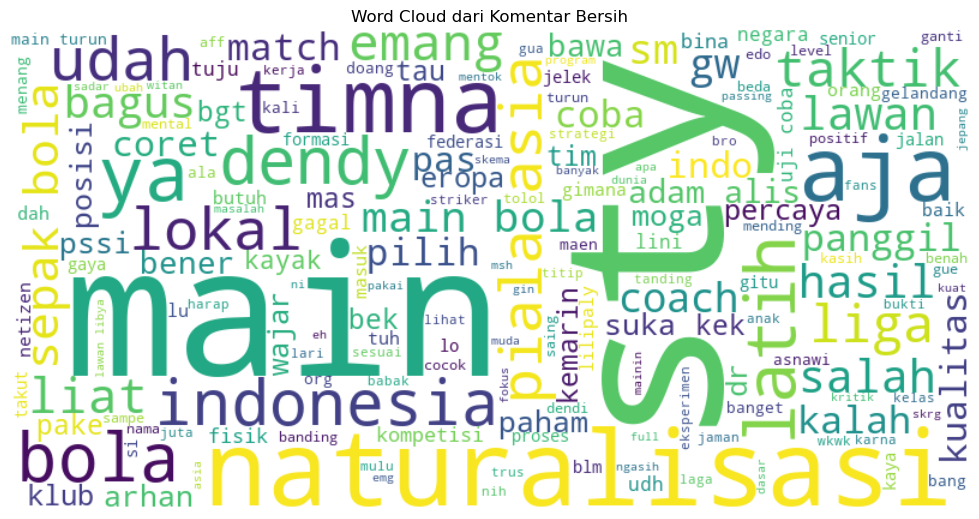


Membuat plot distribusi panjang teks (jumlah kata)...


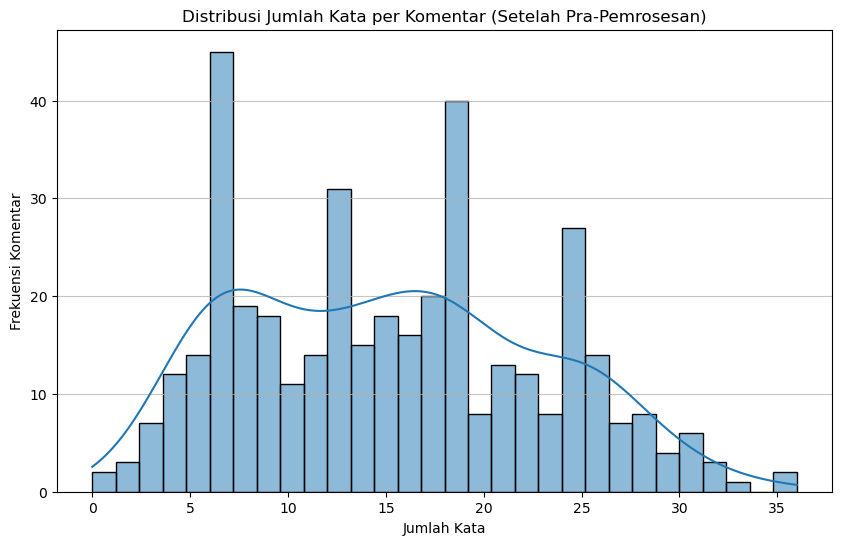


Statistik Deskriptif Jumlah Kata per Komentar Bersih:
count    398.000000
mean      15.168342
std        7.696334
min        0.000000
25%        8.000000
50%       15.000000
75%       21.000000
max       36.000000
Name: jumlah_kata_bersih, dtype: float64

Membuat bar plot frekuensi kata teratas...


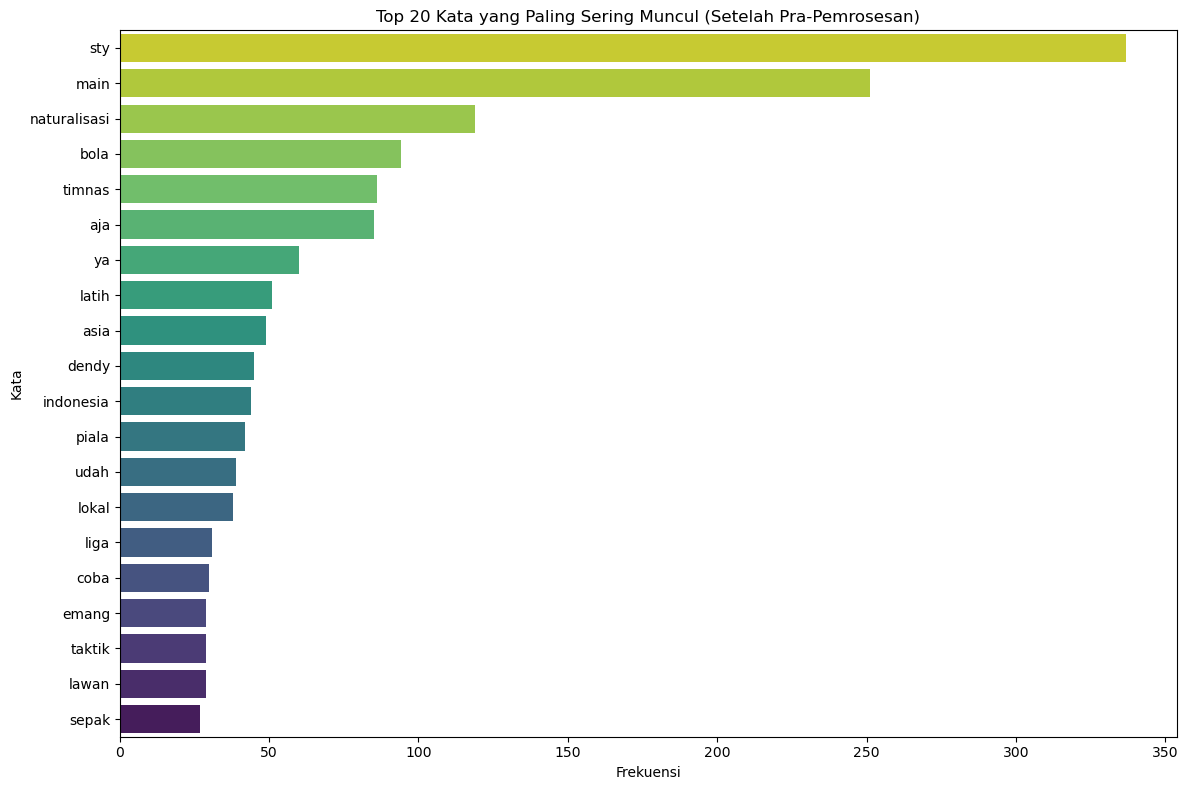

In [8]:
df['komentar_bersih'] = df['komentar_bersih'].astype(str) # Memastikan semua adalah string

# 1. Word Cloud untuk kata-kata yang paling sering muncul
print("\nMembuat Word Cloud...")
all_text_cleaned = " ".join(komentar for komentar in df['komentar_bersih'] if komentar)

if all_text_cleaned.strip():
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis',
                          min_font_size=10).generate(all_text_cleaned)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud dari Komentar Bersih")
    plt.tight_layout(pad=0)
    plt.show()
else:
    print("Tidak ada teks yang cukup untuk membuat Word Cloud setelah pembersihan.")

# 2. Plot distribusi panjang teks 
print("\nMembuat plot distribusi panjang teks (jumlah kata)...")
df['jumlah_kata_bersih'] = df['komentar_bersih'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['jumlah_kata_bersih'], kde=True, bins=30)
plt.title('Distribusi Jumlah Kata per Komentar (Setelah Pra-Pemrosesan)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi Komentar')
plt.grid(axis='y', alpha=0.75)
plt.show()

print("\nStatistik Deskriptif Jumlah Kata per Komentar Bersih:")
print(df['jumlah_kata_bersih'].describe())

# 3. Frekuensi kata dengan bar plot
print("\nMembuat bar plot frekuensi kata teratas...")
all_words_cleaned = []
for komentar in df['komentar_bersih']:
    if komentar: # Pastikan komentar tidak kosong
        all_words_cleaned.extend(komentar.split())

if all_words_cleaned:
    word_counts = Counter(all_words_cleaned)
    top_n_words = 20
    most_common_words = word_counts.most_common(top_n_words)

    # DataFrame untuk plotting
    df_most_common = pd.DataFrame(most_common_words, columns=['Kata', 'Frekuensi'])

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Frekuensi', y='Kata', data=df_most_common, 
                palette='viridis_r', hue='Kata', legend=False)
    plt.title(f'Top {top_n_words} Kata yang Paling Sering Muncul (Setelah Pra-Pemrosesan)')
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada kata yang ditemukan untuk membuat bar plot frekuensi.")

# Bagian 5
Klasifikasi Teks dilakukan dengan menggunakan algoritma Support Vector Classifier dengan GridSearchCV (untuk mencari parameter terbaik), lalu dievaluasi dengan confusion matrix dan beserta skor accuracy, precision, recall, dan F1 score. Dataset dibagia menjadi 80% set training dan 20% set test.

In [10]:
y = df['label']

## Latih dan Evaluasi Model dengan ektraski fitur dari TF-IDF

In [14]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(tfidf_matrix, y, test_size=0.2)

In [16]:
# Mencari parameter terbaik dengan GridSearchCV
svc_model = SVC()
parameters_svc = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}
tfidf_svc = GridSearchCV(svc_model, parameters_svc)

tfidf_svc.fit(X_train_1, y_train_1)

print(tfidf_svc.best_params_) #Menampilkan parameter dengan value terbaik

{'C': 1, 'gamma': 1, 'kernel': 'sigmoid'}


In [17]:
tfidf_model = SVC(C=1, gamma=1, kernel='sigmoid')
tfidf_model.fit(X_train_1, y_train_1)

# Memprediksi data testing dari model SVC
tfidf_model_pred = tfidf_model.predict(X_test_1)

# Melihat jumlah prediksi benar dan salah serta mengukur akurasi pengujian
prediksi_benar = (tfidf_model_pred == y_test_1).sum()
prediksi_salah = (tfidf_model_pred != y_test_1).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 59
Jumlah prediksi salah	: 21
Akurasi pengujian	: 73.75 %


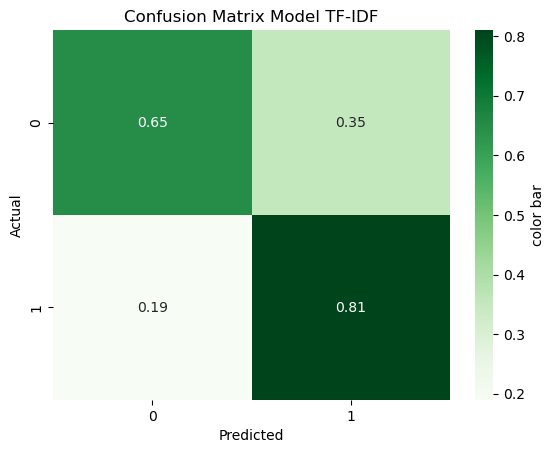

In [22]:
# Confsuion matrix untuk model denan tfidf
cm = confusion_matrix(y_test_1, tfidf_model_pred)
cm
cm_normalized = np.round(cm/np.sum(cm, axis=1).reshape(-1, 1), 2)

# Plot
sns.heatmap(cm_normalized, cmap="Greens", annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Model TF-IDF")
plt.show()

## Latih dan Evaluasi Model dengan ektraski fitur dari Word2Vec

In [19]:
from sklearn.model_selection import train_test_split

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_w2v_features, y, test_size=0.2)

In [20]:
w2v_svc = GridSearchCV(svc_model, parameters_svc)

w2v_svc.fit(X_train_2, y_train_2)

print(w2v_svc.best_params_) #Menampilkan parameter dengan value terbaik

{'C': 1000, 'gamma': 1, 'kernel': 'linear'}


In [21]:
w2v_model = SVC(C=100, gamma=1, kernel='linear')
w2v_model.fit(X_train_2, y_train_2)

# Memprediksi data testing dari model SVC
w2v_model_pred = w2v_model.predict(X_test_2)

# Melihat jumlah prediksi benar dan salah serta mengukur akurasi pengujian
prediksi_benar = (w2v_model_pred == y_test_2).sum()
prediksi_salah = (w2v_model_pred != y_test_2).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 43
Jumlah prediksi salah	: 37
Akurasi pengujian	: 53.75 %


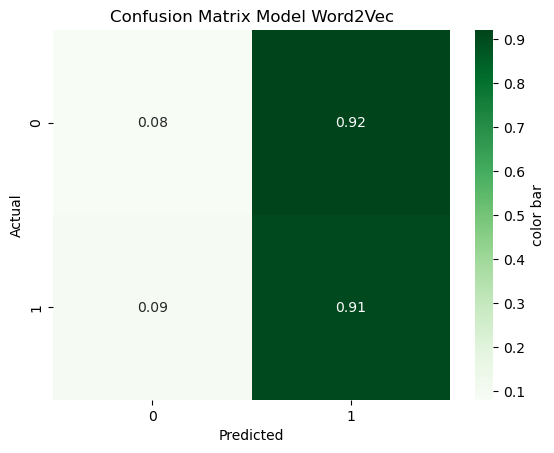

In [24]:
# Confsuion matrix untuk model denan w2v
cm = confusion_matrix(y_test_1, w2v_model_pred)
cm
cm_normalized = np.round(cm/np.sum(cm, axis=1).reshape(-1, 1), 2)

# Plot
sns.heatmap(cm_normalized, cmap="Greens", annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Model Word2Vec")
plt.show()

## Interpretasi Hasil
Model klasifikasi dibuat menggunakan SVM dengan GridSearchCV diuji pada dua jenis representasi teks, yaitu TF-IDF dan Word2Vec.
Model dengan TF-IDF memperoleh akurasi sebesar 73.75%, jauh lebih baik dibandingkan Word2Vec yang hanya mencapai 53.75%, menunjukkan bahwa TF-IDF lebih efektif untuk dataset kecil dan sesuai dengan karakteristik komentar dalam studi ini.

# Bagian 6

## 6. Perbandingan Text Classification dan Text Clustering

Text Classification merupakan metode *supervised learning* yang memerlukan data berlabel untuk mengklasifikasikan teks ke dalam kategori tertentu berdasarkan label yang sudah ada. Sedangkan Text Clustering adalah pendekatan *unsupervised learning* yang mengelompokkan teks berdasarkan kemiripan isi tanpa informasi label sebelumnya.

> *"Classification requires labeled data, whereas clustering groups data based on inherent similarities without prior knowledge of labels."*  
> Aggarwal & Zhai (2012), *Mining Text Data* (hlm. 12, Bab 2.1). Springer.

### Contoh Penggunaan Text Clustering

Clustering cocok diterapkan dalam situasi berikut:
- **Tidak tersedia label:** Misalnya mengelompokkan artikel berita ke dalam topik-topik alami tanpa klasifikasi awal.
- **Eksplorasi pola:** Seperti analisis opini publik di media sosial untuk menemukan tema dominan tanpa tahu kategori.

Contoh kasus: mengelompokkan tweet terkait pemilu guna menemukan isu utama yang sedang dibicarakan masyarakat.

> *"Clustering is valuable in text mining when the objective is to discover hidden patterns or groupings in the absence of predefined labels."*  
> Xu & Tian (2015), *A Comprehensive Survey of Clustering Algorithms* (hlm. 5, Paragraf 2). Ann. Data. Sci.

### Menentukan Jumlah Klaster Optimal dalam K-Means

Dua pendekatan umum:
- **Elbow Method:** Menentukan nilai *k* dengan mengamati titik pelambatan signifikan dalam grafik WCSS (*within-cluster sum of squares*).
- **Silhouette Score:** Mengukur seberapa baik tiap data berada dalam klasternya sendiri dibanding klaster lain; nilai tertinggi menunjukkan *k* terbaik.

> *"The elbow method visualizes the trade-off between WCSS and k, while the silhouette score quantifies cluster cohesion and separation."*  
> Kodinariya & Makwana (2013), *Review on Determining Number of Cluster in K-Means Clustering* (hlm. 4, Bagian 2.2). International Journal of Advance Research in Computer Science and Management.
